In [58]:
%matplotlib inline
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import os
import glob
import pandas as pd
import datetime
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 500)
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

from src.data.processing_func import connect_database
from src.data.load_func import transf_flow_labels

It is important to remember that slots that show up in the following table can contain 1 or 2 signals from Waze. This may impact the model since it is an indicator of the overall duration of the traffic jam, in that section, during that period.

Remember to include that in the model in a future moment.

In [45]:
project_dir = os.path.join(".", os.pardir, os.pardir)

#Get processed datasets
filenames = glob.glob(project_dir+"/data/interim/flow_dataset_*.csv")
filenames.sort()

frame = pd.DataFrame()
list_ = []
for file_ in filenames:
    df = pd.read_csv(file_, index_col=0)
    list_.append(df)
df = pd.concat(list_)
df.reset_index(drop=True, inplace=True)
df = df[['SctnId', 'Endereco', 'SctnDscNome', 'Direction', 'date', 'hour', 'minute_bin',
         'Velocidade Média (km/h)', 'Atraso médio (s)', 'Fila média (m)', 'Nível médio de congestionamento (0 a 5)', 
         'Numero de faixas', 'Ciclofaixa', 'Corredor','Equipamento',
         '00 a 10', '11 a 20', '21 a 30', '31 a 40', '41 a 50', '51 a 60',
         '61 a 70', '71 a 80', '81 a 90', '91 a 100', 'Acima de 100', 'Total',
        ]]
print(df.shape)
df.sample(5)

(5491, 27)


,SctnId,Endereco,SctnDscNome,Direction,date,hour,minute_bin,Velocidade Média (km/h),Atraso médio (s),Fila média (m),Nível médio de congestionamento (0 a 5),Numero de faixas,Ciclofaixa,Corredor,Equipamento,00 a 10,11 a 20,21 a 30,31 a 40,41 a 50,51 a 60,61 a 70,71 a 80,81 a 90,91 a 100,Acima de 100,Total
1327,5138.0,Rua Fátima. 542,FATIMA,South,2017-11-11,14,15 a 29,20.235,138.500000,1780.000000,2.000000,1,0,0,FS640JOI,0,2,15,52,31,4,0,0,0,0,0,104
1940,3476.0,Av. José Vieira X Rua Itaiópolis,ITAIOPOLIS,South,2017-11-21,9,45 a 59,7.710,105.000000,375.000000,3.000000,2,0,1,FS596JOI,0,81,139,93,12,2,0,0,0,0,0,327
562,7383.0,Av. José Vieira X Rua Itaiópolis,AVENIDA JOSE VIEIRA,South,2017-10-30,18,15 a 29,6.850,173.666667,416.666667,3.333333,2,0,1,FS596JOI,4,124,169,51,0,1,0,0,0,0,0,349
4928,13377.0,Rua Iririu 246,IRIRIU,South,2017-10-11,13,30 a 44,11.525,96.000000,443.000000,3.000000,2,0,1,FS599JOI,5,126,148,18,0,0,0,0,0,0,0,297
2847,5138.0,Rua Fátima. 542,FATIMA,South,2017-12-04,18,30 a 44,16.910,100.500000,1129.000000,3.000000,1,0,0,FS640JOI,0,8,18,49,26,3,0,0,0,0,0,104


Points with zero traffic count (Total) are odd, since they are matched with a traffic jam nearby. Let's remove these.

In [46]:
display(df.shape)
display(df[df["Total"]==0].shape)
df = df[df["Total"]!=0]
display(df.shape)

(5491, 27)

(282, 27)

(5209, 27)

Below is the a list of sections with the highest traffic count:

In [53]:
df_rush = df[df["hour"] ==18].sort_values("date")
df_rush = df_rush.groupby(["SctnId", "SctnDscNome", "date"]).agg({"Total": 'sum'})
display(df_rush.sort_values("Total", ascending=False).head(100))
#df_rush.reset_index().plot(x='date', y='Total')
#plt.xticks(rotation=45)


Total
SctnId  SctnDscNome         date             
7480.0  ITAIOPOLIS          2017-11-27   1645
                            2017-11-24   1379
7383.0  AVENIDA JOSE VIEIRA 2017-11-24   1379
                            2017-12-14   1373
7480.0  ITAIOPOLIS          2017-11-23   1371
3476.0  ITAIOPOLIS          2017-11-23   1371
7383.0  AVENIDA JOSE VIEIRA 2017-11-08   1356
7480.0  ITAIOPOLIS          2017-10-31   1352
                            2017-11-13   1348
7383.0  AVENIDA JOSE VIEIRA 2017-10-20   1347
7480.0  ITAIOPOLIS          2017-10-18   1337
7383.0  AVENIDA JOSE VIEIRA 2017-10-18   1337
                            2017-11-01   1336
7480.0  ITAIOPOLIS          2017-10-17   1333
7383.0  AVENIDA JOSE VIEIRA 2017-10-10   1331
7480.0  ITAIOPOLIS          2017-10-10   1331
13377.0 IRIRIU              2017-10-18   1329
7383.0  AVENIDA JOSE VIEIRA 2017-11-17   1327
7480.0  ITAIOPOLIS          2017-11-17   1327
7383.0  AVENIDA JOSE VIEIRA 2017-12-01   1323
                            2017-11-30   1317
7480.0  ITAIOPOLIS          2017-10-24   1312
3476.0  ITAIOPOLIS          2017-10-24   1312
7383.0  AVENIDA JOSE VIEIRA 2017-11-14   1302
3476.0  ITAIOPOLIS          2017-10-23   1299
7480.0  ITAIOPOLIS          2017-10-23   1299
7383.0  AVENIDA JOSE VIEIRA 2017-11-21   1294
3476.0  ITAIOPOLIS          2017-10-09   1292
7480.0  ITAIOPOLIS          2017-10-09   1292
3476.0  ITAIOPOLIS          2017-10-16   1287
...                                       ...
7480.0  ITAIOPOLIS          2017-10-19    968
7383.0  AVENIDA JOSE VIEIRA 2017-10-27    966
3476.0  ITAIOPOLIS          2017-12-15    965
7480.0  ITAIOPOLIS          2017-12-15    965
                            2017-12-18    960
7383.0  AVENIDA JOSE VIEIRA 2017-10-06    960
7480.0  ITAIOPOLIS          2017-10-25    957
3476.0  ITAIOPOLIS          2017-10-25    957
7383.0  AVENIDA JOSE VIEIRA 2017-10-25    957
                            2017-10-09    944
                            2017-11-06    944
7480.0  ITAIOPOLIS          2017-11-11    943
                            2017-11-20    935
                            2017-11-03    930
                            2017-12-19    905
10496.0 BENJAMIN CONSTANT   2017-10-09    812
13377.0 IRIRIU              2017-11-09    774
10496.0 BENJAMIN CONSTANT   2017-11-24    754
7383.0  AVENIDA JOSE VIEIRA 2017-11-22    707
3476.0  ITAIOPOLIS          2017-11-22    707
7480.0  ITAIOPOLIS          2017-10-26    703
7383.0  AVENIDA JOSE VIEIRA 2017-11-28    702
7480.0  ITAIOPOLIS          2017-12-05    701
3476.0  ITAIOPOLIS          2017-12-05    701
7383.0  AVENIDA JOSE VIEIRA 2017-12-08    692
7480.0  ITAIOPOLIS          2017-12-12    692
3476.0  ITAIOPOLIS          2017-12-08    692
                            2017-11-29    682
7383.0  AVENIDA JOSE VIEIRA 2017-12-15    676
7480.0  ITAIOPOLIS          2017-10-20    674

[100 rows x 1 columns]

Due to buffer approximations, some radars belong simultaneously to more than one street section with similar traffic indicators. In those cases, for simplicity matters, we will just keep the first section.

In [4]:
display(df[["Equipamento", "SctnId", "Direction", "date", "hour",
          "minute_bin", "Velocidade Média (km/h)", "Total"]][df["Equipamento"]=="FS596JOI"].\
      sort_values(["date", "hour", "minute_bin"]).tail(10))

df.drop_duplicates(["Equipamento", "Direction", "date", "hour",
          "minute_bin", "Velocidade Média (km/h)"], inplace=True)

df[["Equipamento", "SctnId", "Direction", "date", "hour",
          "minute_bin", "Velocidade Média (km/h)", "Total"]][df["Equipamento"]=="FS596JOI"].\
      sort_values(["date", "hour", "minute_bin"]).tail(10)

,Equipamento,SctnId,Direction,date,hour,minute_bin,Velocidade Média (km/h),Total
4396,FS596JOI,7480.0,South,2017-12-26,9,30 a 44,12.99,240
4393,FS596JOI,7383.0,South,2017-12-26,18,0 a 14,5.78,305
4359,FS596JOI,3476.0,South,2017-12-26,18,15 a 29,10.53,309
4394,FS596JOI,7383.0,South,2017-12-26,18,15 a 29,5.48,309
4360,FS596JOI,3476.0,South,2017-12-26,18,30 a 44,10.92,260
4361,FS596JOI,3476.0,South,2017-12-27,16,45 a 59,9.46,254
4362,FS596JOI,3476.0,South,2017-12-29,19,0 a 14,7.18,210
4363,FS596JOI,3476.0,South,2017-12-29,19,15 a 29,7.14,261
4364,FS596JOI,3476.0,South,2017-12-30,12,15 a 29,5.79,189
4365,FS596JOI,3476.0,South,2017-12-30,21,0 a 14,14.18,185


,Equipamento,SctnId,Direction,date,hour,minute_bin,Velocidade Média (km/h),Total
4396,FS596JOI,7480.0,South,2017-12-26,9,30 a 44,12.99,240
4393,FS596JOI,7383.0,South,2017-12-26,18,0 a 14,5.78,305
4359,FS596JOI,3476.0,South,2017-12-26,18,15 a 29,10.53,309
4394,FS596JOI,7383.0,South,2017-12-26,18,15 a 29,5.48,309
4360,FS596JOI,3476.0,South,2017-12-26,18,30 a 44,10.92,260
4361,FS596JOI,3476.0,South,2017-12-27,16,45 a 59,9.46,254
4362,FS596JOI,3476.0,South,2017-12-29,19,0 a 14,7.18,210
4363,FS596JOI,3476.0,South,2017-12-29,19,15 a 29,7.14,261
4364,FS596JOI,3476.0,South,2017-12-30,12,15 a 29,5.79,189
4365,FS596JOI,3476.0,South,2017-12-30,21,0 a 14,14.18,185


Preparing training dataset

In [5]:
X = df[['Velocidade Média (km/h)', 'Nível médio de congestionamento (0 a 5)', 'Atraso médio (s)',
       'Fila média (m)', 'Numero de faixas', 'Ciclofaixa', 'Corredor']]
y = df['Total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

clf = linear_model.LinearRegression()

clf.fit(X_train,y_train)
display(clf.score(X_test, y_test))


(3535, 7)

(1179, 7)

(3535,)

(1179,)

0.68314936963419282

In [6]:
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train,y_train)
neigh.score(X_test, y_test)

0.40410168549635461

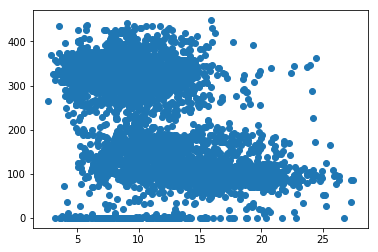

In [152]:
plt.scatter(X['Velocidade Média (km/h)'], y)
plt.show()

In [66]:
df["V_squared"] = df['Velocidade Média (km/h)']**2
df["V_cubic"] = df['Velocidade Média (km/h)']**3
df2 = df[df['Numero de faixas']>1]
df2 = df2[df2["Total"]>50]
df2 = df2[df2["hour"]==18]
X2 = df2['Velocidade Média (km/h)'].values.reshape(-1,1)
y2 = df2['Total']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=0)

display(X2_train.shape)
display(X2_test.shape)
display(y2_train.shape)
display(y2_test.shape)

clf = linear_model.LinearRegression()

clf.fit(X2_train,y2_train)
display(clf.score(X2_test, y2_test))

neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X2_train,y2_train)
display(neigh.score(X2_test, y2_test))




(275, 1)

(92, 1)

(275,)

(92,)

-0.066792593555848656

-0.14708503156345754

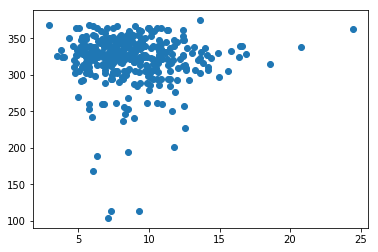

In [67]:
plt.scatter(X2, y2)
plt.show()

In [2]:
DATABASE = {
'drivername': os.environ.get("db_drivername"),
'host': os.environ.get("db_host"), 
'port': os.environ.get("db_port"),
'username': os.environ.get("db_username"),
'password': os.environ.get("db_password"),
'database': os.environ.get("db_database"),
}

meta = connect_database(DATABASE)

path_fluxos = project_dir + "/data/external/fotosensores_Fluxo_veiculos.csv"
df_flow = transf_flow_labels(meta, path_fluxos)
df_flow.shape

(164160, 20)

In [64]:
df_flow[df_flow["SctnDscNome"]=="ITAIOPOLIS"].sample(5)
display(df_flow.index.get_level_values("Direction").unique())

Index(['West', 'East', 'North', 'South'], dtype='object', name='Direction')

,Total
date,
2017-10-03,2572
2017-10-04,2604
2017-10-05,2516
2017-10-06,2548
2017-10-07,2536
2017-10-08,2348
2017-10-09,2584
2017-10-10,2662
2017-10-11,2624


,Total
date,


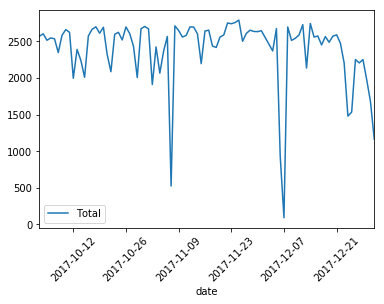

In [59]:
monsenhor = df_flow[df_flow["SctnDscNome"] == "ITAIOPOLIS"]
monsenhor = monsenhor.xs(18, level="hour").sort_index(level="date")
monsenhor = monsenhor.groupby(level="date").agg({"Total": 'sum'})
monsenhor = monsenhor[monsenhor["Total"] != 0]
display(monsenhor)

ax = monsenhor.reset_index().plot(x='date', y='Total')
plt.xticks(rotation=45)

monsenhor[monsenhor["Total"]<60]